In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic, great_circle
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.cluster import DBSCAN

In [3]:
csv_path = os.path.join(os.getcwd(), "uber.csv")
df = pd.read_csv(csv_path)

In [4]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [5]:
df['fare_amount'].describe()

count    200000.000000
mean         11.359955
std           9.901776
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [6]:
df['passenger_count'].describe()

count    200000.000000
mean          1.684535
std           1.385997
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

As we can see there is a lot of dirty data. We need to clean the dataset and extract the bad rows. Put the bad rows in an exemption list.

In [7]:
# Assuming 'df' is your original DataFrame

# Convert 'pickup_datetime' to a Python datetime object, setting errors='coerce' to handle invalid dates
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Create a condition to filter out rows with invalid or NaT (Not-a-Time) datetime values
condition_invalid_datetime = df['pickup_datetime'].isna()

# Define the condition to filter out rows with latitude/longitude values outside the [-90, 90] range
condition_out_of_range = (
    (df['pickup_longitude'] < -90) | (df['pickup_longitude'] > 90) |
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['dropoff_longitude'] < -90) | (df['dropoff_longitude'] > 90) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)
)

# Create a condition to filter out rows where fare_amount is less than or equal to 0
condition_invalid_fare = df['fare_amount'] <= 0

# Create a condition to filter out rows where any latitude/longitude column has NaN values
condition_nan_coordinates = (
    df['pickup_longitude'].isna() |
    df['pickup_latitude'].isna() |
    df['dropoff_longitude'].isna() |
    df['dropoff_latitude'].isna()
)

# Create a condition to filter out rows where passenger_count is 0
condition_zero_passenger = df['passenger_count'] <= 0

# Create a condition to filter out rows where passenger_count is greater than 10
condition_high_passenger_count = df['passenger_count'] > 10

# Combine all conditions, including the invalid datetime condition and high passenger count
initial_condition_combined = (
    condition_out_of_range |
    condition_invalid_fare |
    condition_nan_coordinates |
    condition_zero_passenger |
    condition_invalid_datetime |
    condition_high_passenger_count
)

# Extract rows that meet the initial condition into the 'dropped' DataFrame
dropped = df[initial_condition_combined].copy()

# Remove these rows from the original DataFrame
df = df[~initial_condition_combined].copy()

# Now calculate 'distance_miles' using the geodesic formula on the filtered DataFrame
df['distance_miles'] = df.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).miles, axis=1)

# Create a condition to filter out rows where distance_miles is less than or equal to 0
condition_invalid_distance = df['distance_miles'] <= 0

# Add rows with invalid distance to the 'dropped' DataFrame
dropped = pd.concat([dropped, df[condition_invalid_distance]])

# Remove rows with invalid distance from the main DataFrame
df = df[~condition_invalid_distance].copy()

In [8]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.044594
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,1.525071
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,3.131464
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.032372
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2.786061
...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.069673
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1.167951
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,7.995752
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,2.197512


In [9]:
dropped

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles
333,2137942,2011-08-05 07:03:08.0000001,10.1,2011-08-05 07:03:08+00:00,-74.013900,40.707800,-73.992300,40.749300,0,NaN
908,8484351,2011-09-06 12:25:19.0000002,11.7,2011-09-06 12:25:19+00:00,-73.981000,40.764600,-73.962900,40.778400,0,NaN
926,32941306,2012-03-26 18:11:24.0000002,3.3,2012-03-26 18:11:24+00:00,-73.979978,40.765821,-73.983894,40.766873,0,NaN
2000,12591041,2012-04-20 15:07:57.0000003,15.7,2012-04-20 15:07:57+00:00,-73.975285,40.750138,-73.974729,40.783151,0,NaN
3011,39400625,2012-01-07 19:19:08.0000004,6.1,2012-01-07 19:19:08+00:00,-73.977900,40.789100,-73.983700,40.773600,0,NaN
...,...,...,...,...,...,...,...,...,...,...
199880,35013970,2014-02-22 06:45:46.0000002,6.5,2014-02-22 06:45:46+00:00,0.000000,0.000000,0.000000,0.000000,1,0.0
199883,44115598,2012-09-10 17:39:00.00000090,12.5,2012-09-10 17:39:00+00:00,0.000000,0.000000,0.000000,0.000000,2,0.0
199917,45368488,2013-06-24 22:17:43.0000002,4.5,2013-06-24 22:17:43+00:00,-73.793768,40.656939,-73.793768,40.656939,1,0.0
199932,46517645,2011-03-22 13:59:00.00000018,24.9,2011-03-22 13:59:00+00:00,-73.974618,40.756295,-73.974618,40.756295,5,0.0


Now that we cleaned the data, let's calculate insights we will need later including:

fare per mile

fare per person

In [10]:
# Calculate fare per mile
df['fare_per_mile'] = df['fare_amount'] / df['distance_miles']

# Calculate fare per person
df['fare_per_person'] = df['fare_amount'] / df['passenger_count']

In [11]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles,fare_per_mile,fare_per_person
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.044594,7.179824,7.500000
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,1.525071,5.048947,7.700000
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,3.131464,4.119479,12.900000
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.032372,5.133809,1.766667
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2.786061,5.742876,3.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.069673,43.058102,3.000000
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1.167951,6.421501,7.500000
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,7.995752,3.864552,15.450000
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,2.197512,6.598372,14.500000


In [12]:
'''
Insights
'''
avg_fare_per_mile = df['fare_per_mile'].mean()
print(f"Average fare per mile: ${avg_fare_per_mile:.2f}")
med_fare_per_mile = df['fare_per_mile'].median()
print(f"Median fare per mile: ${med_fare_per_mile:.2f}")


Average fare per mile: $136.76
Median fare per mile: $6.14


In [13]:
print(df['distance_miles'].describe())

count    193643.000000
mean         12.983572
std         237.498589
min           0.000052
25%           0.796836
50%           1.357833
75%           2.460407
max        5457.871964
Name: distance_miles, dtype: float64


In [14]:
print(df['fare_per_mile'].describe())

count    1.936430e+05
mean     1.367571e+02
std      7.439362e+03
min      4.637810e-04
25%      4.772069e+00
50%      6.143933e+00
75%      8.123481e+00
max      1.072299e+06
Name: fare_per_mile, dtype: float64


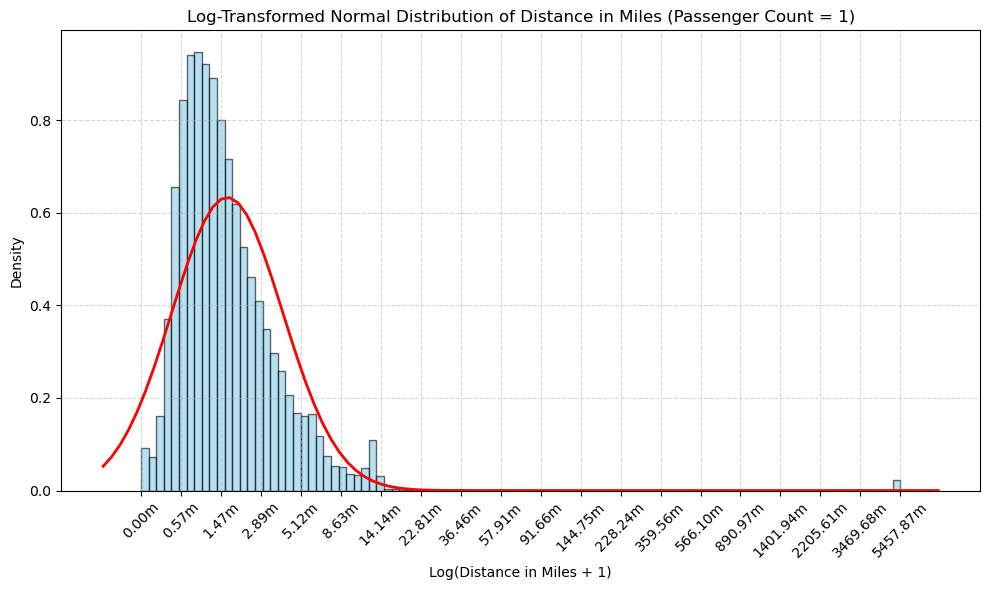

In [15]:
# Assuming 'df' is your original DataFrame
# Filter the DataFrame to only include rows where passenger_count == 1
df_single_passenger = df[df['passenger_count'] == 1].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Apply a log transformation to fare_per_mile to handle the wide range
df_single_passenger['log_distance_miles'] = np.log1p(df_single_passenger['distance_miles'])  # log1p handles log(0) safely as log(1 + x)

# Plotting the histogram of log-transformed fare_per_mile
plt.figure(figsize=(10, 6))
plt.hist(df_single_passenger['log_distance_miles'], bins=100, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating mean and standard deviation of the log-transformed fare_per_mile column
mean = df_single_passenger['log_distance_miles'].mean()
std_dev = df_single_passenger['log_distance_miles'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2)

# Adding plot title and labels
plt.title('Log-Transformed Normal Distribution of Distance in Miles (Passenger Count = 1)')
plt.xlabel('Log(Distance in Miles + 1)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

# Set the x-ticks to cover the range, and show their original fare_per_mile equivalents
ticks = np.linspace(df_single_passenger['log_distance_miles'].min(), df_single_passenger['log_distance_miles'].max(), num=20)
plt.xticks(ticks, labels=[f"{np.exp(tick) - 1:.2f}m" for tick in ticks], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

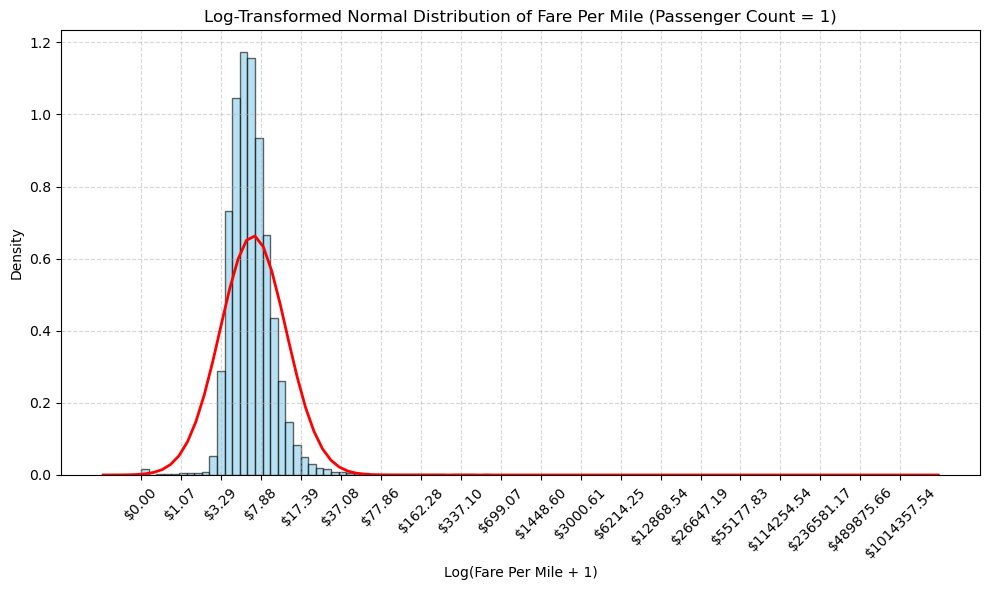

In [16]:
'''
Standard distribution of fare_per_mile. Looks like most people are paying ~$5 per mile.
Note that this is also for 1-x passangers...
'''

# Assuming 'df' is your original DataFrame
# Filter the DataFrame to only include rows where passenger_count == 1
df_single_passenger = df[df['passenger_count'] == 1].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Apply a log transformation to fare_per_mile to handle the wide range
df_single_passenger['log_fare_per_mile'] = np.log1p(df_single_passenger['fare_per_mile'])  # log1p handles log(0) safely as log(1 + x)

# Plotting the histogram of log-transformed fare_per_mile
plt.figure(figsize=(10, 6))
plt.hist(df_single_passenger['log_fare_per_mile'], bins=100, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating mean and standard deviation of the log-transformed fare_per_mile column
mean = df_single_passenger['log_fare_per_mile'].mean()
std_dev = df_single_passenger['log_fare_per_mile'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2)

# Adding plot title and labels
plt.title('Log-Transformed Normal Distribution of Fare Per Mile (Passenger Count = 1)')
plt.xlabel('Log(Fare Per Mile + 1)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

# Set the x-ticks to cover the range, and show their original fare_per_mile equivalents
ticks = np.linspace(df_single_passenger['log_fare_per_mile'].min(), df_single_passenger['log_fare_per_mile'].max(), num=20)
plt.xticks(ticks, labels=[f"${np.exp(tick) - 1:.2f}" for tick in ticks], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


Fare per trip population

Given the statistics for fare_amount, it looks like most of the data is concentrated between $0.01 and around $25, with a small number of extreme values reaching up to $499. To create the best plot for this data, we need to adjust a few things to handle this skewness and the presence of outliers:

Log Transformation: Since there is a wide range of values and many smaller fares, applying a log transformation will help visualize the distribution more clearly without the high values distorting the scale.
Increase the Number of Bins: Using more bins will capture more details of the distribution.


In [17]:
df['fare_amount'].describe()

count    193643.000000
mean         11.363200
std           9.757247
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

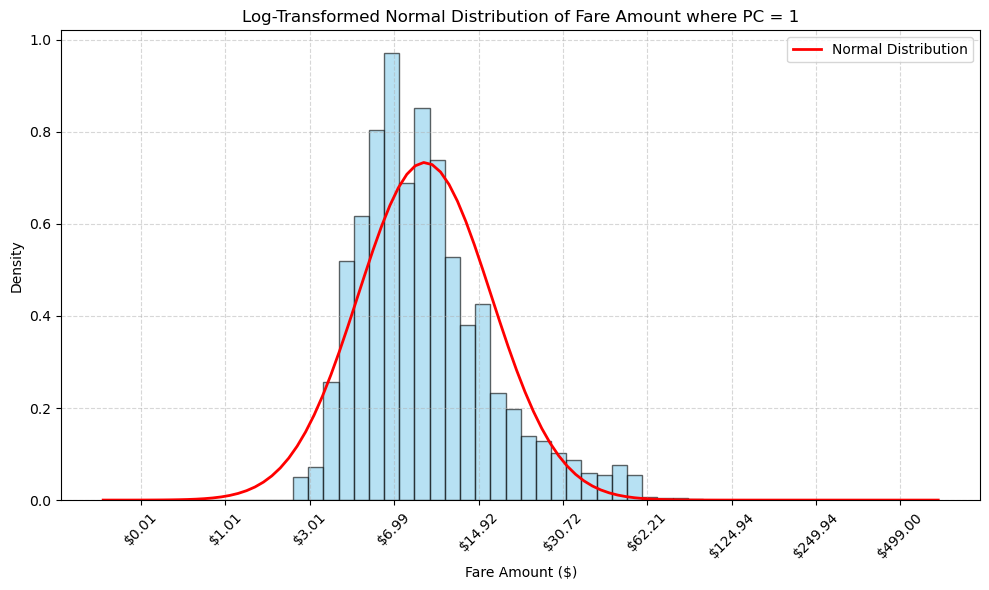

In [18]:
# Assuming 'df' is your original DataFrame
# Filter the DataFrame to only include rows where passenger_count == 1
df_single_passenger = df[df['passenger_count'] == 1].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Apply a log transformation to the fare_amount to handle the skewness
df_single_passenger['log_fare_amount'] = np.log1p(df_single_passenger['fare_amount'])  # log1p handles log(0) safely as log(1 + x)

# Plotting the histogram of the log-transformed fare_amount
plt.figure(figsize=(10, 6))
plt.hist(df_single_passenger['log_fare_amount'], bins=50, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating mean and standard deviation of the log-transformed fare_amount column
mean = df_single_passenger['log_fare_amount'].mean()
std_dev = df_single_passenger['log_fare_amount'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

# Set x-ticks to reflect the original fare_amount values (converting back from the log scale)
ticks = np.linspace(df_single_passenger['log_fare_amount'].min(), df_single_passenger['log_fare_amount'].max(), num=10)
plt.xticks(ticks, labels=[f"${np.expm1(tick):.2f}" for tick in ticks], rotation=45)

# Adding plot title and labels
plt.title('Log-Transformed Normal Distribution of Fare Amount where PC = 1')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Plot the population of the fare per person

Given the statistics for fare_per_person, we observe that most values are concentrated between $0.01 and around $25, but with a small number of outliers going up to $499. To visualize this effectively, we should:

Use a Log Transformation: This will help manage the skew caused by the large range of values and make the distribution easier to interpret.
Adjust the number of bins: Using more bins will capture more details of the distribution.

In [19]:
df['fare_per_person'].describe()

count    193643.000000
mean          9.112823
std           9.017515
min           0.010000
25%           4.100000
50%           6.900000
75%          10.500000
max         499.000000
Name: fare_per_person, dtype: float64

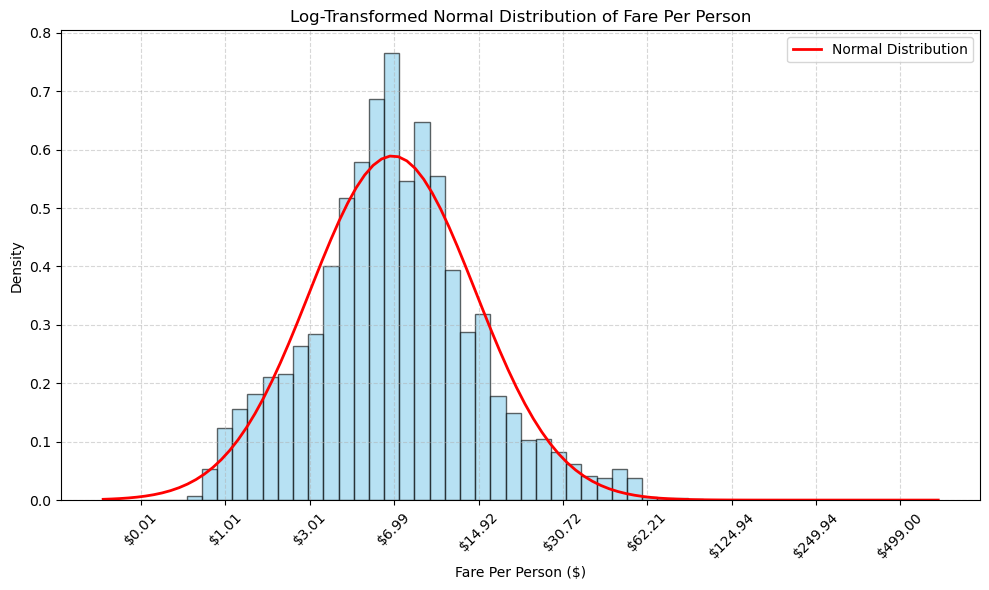

In [20]:
# Make a copy of the DataFrame to preserve the original data
df_transformed = df.copy()

# Apply a log transformation to fare_per_person on the copied DataFrame
df_transformed['log_fare_per_person'] = np.log1p(df_transformed['fare_per_person'])  # log1p handles log(0) safely as log(1 + x)

# Plotting the histogram of the log-transformed fare_per_person
plt.figure(figsize=(10, 6))
plt.hist(df_transformed['log_fare_per_person'], bins=50, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating mean and standard deviation of the log-transformed fare_per_person column
mean = df_transformed['log_fare_per_person'].mean()
std_dev = df_transformed['log_fare_per_person'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

# Set x-ticks to show the original fare_per_person values (converting back from the log scale)
ticks = np.linspace(df_transformed['log_fare_per_person'].min(), df_transformed['log_fare_per_person'].max(), num=10)
plt.xticks(ticks, labels=[f"${np.expm1(tick):.2f}" for tick in ticks], rotation=45)

# Adding plot title and labels
plt.title('Log-Transformed Normal Distribution of Fare Per Person')
plt.xlabel('Fare Per Person ($)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

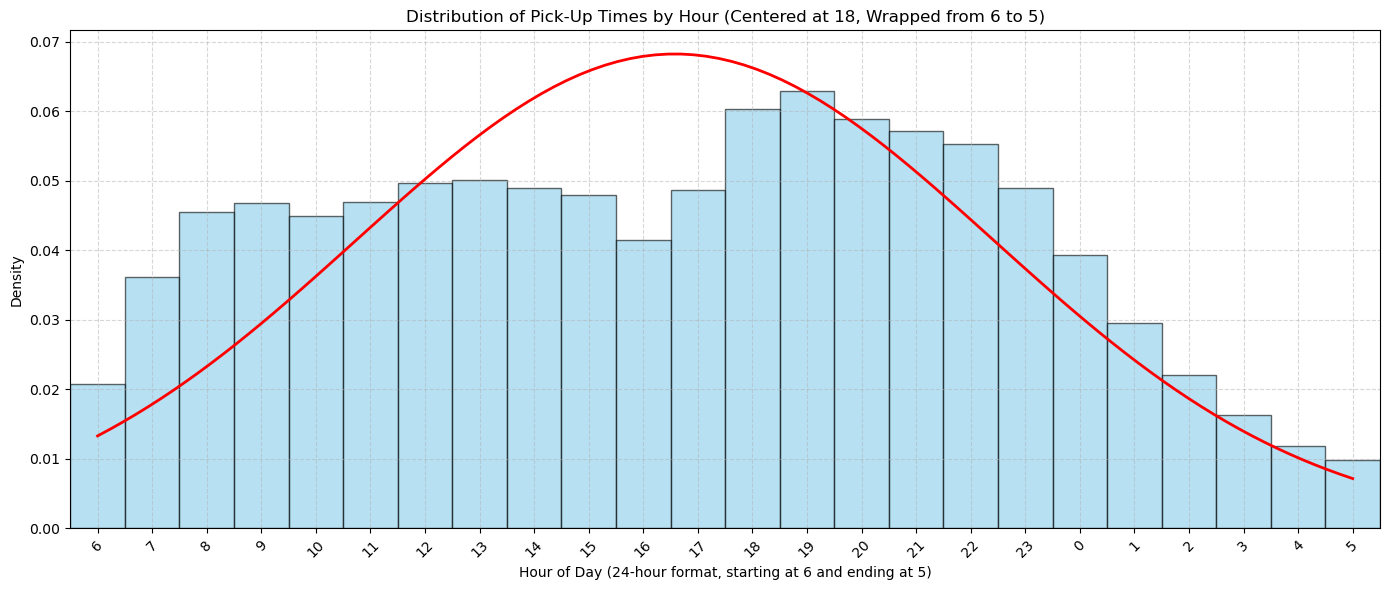

In [21]:
'''
Standard distribution of pickup_datetime
'''

# Make a copy of the DataFrame to preserve the original data
df_transformed = df.copy()

# Assuming 'df' is your original DataFrame containing 'pickup_datetime' column

# Extract the hour from 'pickup_datetime'
df_transformed['pickup_hour'] = df_transformed['pickup_datetime'].dt.hour

# Adjust the pickup_hour column to simulate wrapping for hours beyond 23 (add 24 to hours from 0-5)
df_transformed['adjusted_hour'] = df_transformed['pickup_hour'].apply(lambda x: x if x >= 6 else x + 24)

# Plotting the histogram of adjusted_hour
plt.figure(figsize=(14, 6))
plt.hist(df_transformed['adjusted_hour'], bins=np.arange(5.5, 30.5, 1), density=True, edgecolor='black', alpha=0.6, color='skyblue', align='mid')

# Calculate the mean and standard deviation of the adjusted hour distribution
mean = df_transformed['adjusted_hour'].mean()
std_dev = df_transformed['adjusted_hour'].std()

# Generate values for the normal distribution curve
x = np.linspace(6, 29, 100)
p = norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, p, 'r', linewidth=2)

# Adjust the x-ticks to include hours from 6 to 23 and then 0 to 5
centered_hours = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
centered_labels = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

plt.xticks(centered_hours, labels=centered_labels, rotation=45)

# Extend xlim slightly to ensure no cutting-off at edges
plt.xlim(5.5, 29.5)

# Adding plot title and labels
plt.title('Distribution of Pick-Up Times by Hour (Centered at 18, Wrapped from 6 to 5)')
plt.xlabel('Hour of Day (24-hour format, starting at 6 and ending at 5)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [22]:

total_distance = df['distance_miles'].sum()
print(f"Total distance traveled: {total_distance:.2f} miles")

Total distance traveled: 2514177.85 miles


In [23]:

avg_fare_by_passenger = df.groupby('passenger_count')['fare_amount'].mean()
print(avg_fare_by_passenger)

passenger_count
1    11.242481
2    11.790514
3    11.468416
4    11.662387
5    11.242286
6    12.200516
Name: fare_amount, dtype: float64


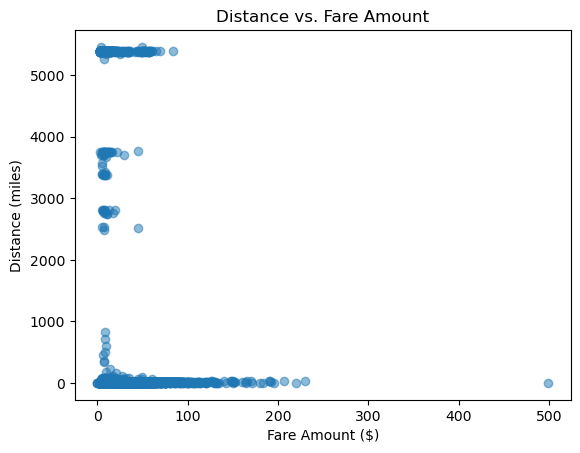

In [24]:
'''
You would expect this to be a linear relationship, as distance increases the price increases, but this isn't the case.
'''
plt.scatter(df['fare_amount'], df['distance_miles'], alpha=0.5)
plt.title('Distance vs. Fare Amount')
plt.ylabel('Distance (miles)')
plt.xlabel('Fare Amount ($)')
plt.show()


In [25]:
# Select key numerical columns for correlation analysis
numerical_columns = ['fare_amount', 'distance_miles', 'passenger_count']

# Extract the relevant numerical data
df_numerical = df[numerical_columns]

# Drop rows with NaN values to avoid issues in correlation calculation
df_numerical = df_numerical.dropna()

# Calculate the correlation matrix
correlation_matrix = df_numerical.corr()
correlation_matrix

,fare_amount,distance_miles,passenger_count
fare_amount,1.000000,0.026442,0.011622
distance_miles,0.026442,1.000000,-0.001496
passenger_count,0.011622,-0.001496,1.000000


1. Correlation Between fare_amount and distance_miles (0.026011)
Interpretation: The correlation coefficient is approximately 0.026, indicating a very weak positive relationship between fare_amount and distance_miles.

Implications:
This result suggests that fare_amount is not strongly dependent on distance_miles alone. 
While longer trips are generally expected to have higher fares, other factors (e.g., traffic, time of day, surge pricing, and fixed base fares) 
likely play significant roles in determining the total fare.

For Uber's business model, this means that charging customers is not solely based on distance traveled; 
pricing strategies such as surge pricing, base fares, and dynamic pricing likely have a substantial impact.



2. Correlation Between fare_amount and passenger_count (0.011824)
Interpretation: The correlation coefficient is approximately 0.012, indicating a very weak positive relationship between fare_amount and passenger_count.

Implications:
This suggests that the number of passengers has little to no impact on the fare amount. 
In most cases, Uber charges the same fare regardless of whether there is one passenger or multiple passengers in the ride.

This aligns with Uber's standard fare structure, where fares are based on distance, time, and demand rather than the number of passengers, 
making Uber rides attractive for groups since the cost doesn't increase per additional passenger.



3. Correlation Between distance_miles and passenger_count (-0.002111)
Interpretation: The correlation coefficient is approximately -0.002, indicating virtually no relationship between distance_miles and passenger_count.

Implications:
This result suggests that trip distances are independent of the number of passengers. Whether there’s one passenger or more does not affect the length of the trips being taken.

This indicates that Uber services cater equally to individual riders and groups for various distances, supporting Uber's ability to serve both short and long-distance trips effectively.


1. Axes Interpretation
X-Axis (pickup_hour): Represents the hours of the day (ranging from 0 to 23 in a 24-hour format). This shows when trips are happening throughout the day.
Y-Axis (passenger_count): Represents the number of passengers per trip (ranging from 1 to 6).

2. Color Intensity or Contour Lines
Heatmap Colors: The color gradient or contour lines represent the density of data points in different regions.
Darker or More Intense Colors: Indicates areas with a high density of data points. This means that a large number of trips with specific passenger counts occur during those hours.
Lighter Colors: Represents lower densities, meaning fewer trips with that combination of pickup_hour and passenger_count.

3. Peak Regions (The Center of the Distribution)
The region where the contour lines are closest together or the color is darkest shows where the most common combinations occur.
For example, if you see a dark/intense region around pickup_hour = 18 (6 PM) and passenger_count = 1, it indicates that many trips with 1 passenger occur around 6 PM.

4. Spread and Shape of the Contours
Tight Contours: Where the contour lines are closely packed, there is a rapid change in density. This means a high concentration of trips with similar characteristics (e.g., a peak rush hour).
Wider Contours: Indicate a broader distribution, showing that trips are spread out across a range of hours or passenger counts.
Shape of the Distribution:
If the contours form an elongated shape, there’s some correlation between pickup_hour and passenger_count.
If the contours are more circular, there's little or no correlation.

5. Comparing the Scatter Plot with the Contours
The red scatter points represent actual data points from your dataset.
If many of the scatter points fall within the densest (darkest) contour regions, it confirms that the normal distribution model closely represents your data.
Example Interpretation
Peak Hours: If the highest density is around pickup_hour = 17 (5 PM) with passenger_count = 1, this means most trips with a single passenger occur around that time.
Off-Peak Hours: Lighter contour areas indicate fewer trips. For example, around pickup_hour = 2 AM, you may find fewer trips regardless of passenger count.
Passenger Patterns: If the contours show that trips with 2 passengers occur more frequently during a specific hour, it reveals a pattern in shared rides during that period.


Key Takeaways from the Plot
Peak travel times: Identify when the majority of trips take place.
Common passenger counts: See how passenger counts vary throughout the day (e.g., more single-passenger trips during certain hours).
Correlation Insight: Determine if there’s any relationship between the time of day and the number of passengers.
How This Visualization Helps
Understand peak hours and how trip passenger counts change throughout the day.
Identify opportunities for marketing, pricing adjustments, or optimizing vehicle availability.

In [26]:
df['passenger_count'].describe()

count    193643.000000
mean          1.689785
std           1.305595
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

In [27]:
df['pickup_datetime'].describe()

count                                 193643
mean     2012-03-24 22:01:53.803747072+00:00
min                2009-01-01 01:15:22+00:00
25%         2010-08-21 21:56:41.500000+00:00
50%                2012-03-27 17:41:17+00:00
75%                2013-10-24 16:13:00+00:00
max                2015-06-30 23:40:39+00:00
Name: pickup_datetime, dtype: object

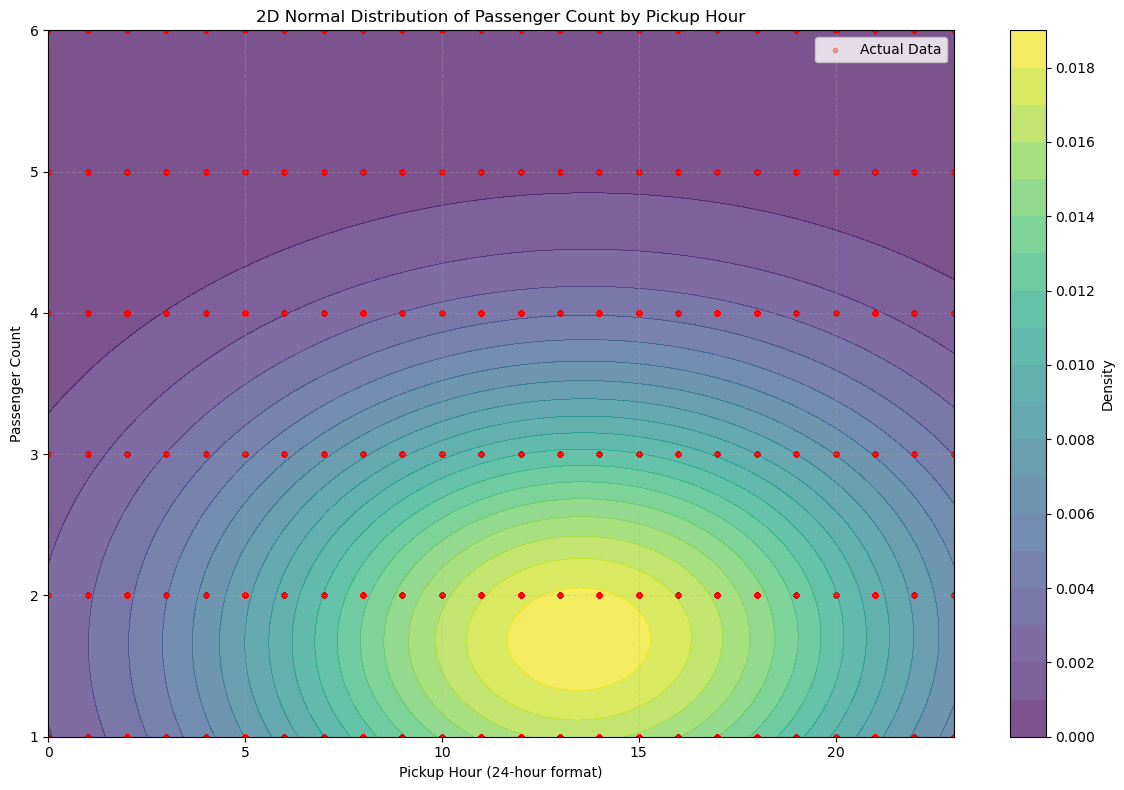

In [28]:
# Make a copy of the DataFrame to preserve the original data
df_transformed = df.copy()

# Extract the hour from 'pickup_datetime'
df_transformed['pickup_hour'] = df_transformed['pickup_datetime'].dt.hour

# Extract the pickup hour and passenger count as separate arrays
pickup_hours = df_transformed['pickup_hour'].values
passenger_counts = df_transformed['passenger_count'].values

# Create a grid for the 2D plot
#This function generates 100 equally spaced values between 0 and 23, representing possible pickup hours in a day.
x = np.linspace(0, 23, 400)  # Pickup hours range from 0 to 23
#Generates 100 equally spaced values from 1 to the maximum passenger_count in your dataset. This represents possible passenger counts.
y = np.linspace(1, df_transformed['passenger_count'].max(), 400)  # Passenger count ranges from 1 to max (6 in this case)

#X and Y are 2D arrays created from the x and y values, representing a grid of coordinates.
#X has rows repeating the x values (pickup hours), and Y has columns repeating the y values (passenger counts).
X, Y = np.meshgrid(x, y)

#Combines X and Y into a single 3D array. Each element in pos is a coordinate pair
#(x,y), representing all combinations of pickup hours and passenger counts across the grid.
pos = np.dstack((X, Y))

# Calculate the mean and covariance matrix for the 2D normal distribution
'''
df_transformed['passenger_count'].mean()] calculates the mean (average) of pickup_hour and passenger_count.
This creates a mean vector that represents the "center" of the normal distribution.
'''
mean = [df_transformed['pickup_hour'].mean(), df_transformed['passenger_count'].mean()]

'''
Computes the covariance matrix, which measures the relationship between pickup_hour and passenger_count.
The covariance matrix shows how these two variables vary together.
It helps in understanding how the spread of one variable changes with respect to the other.
'''
covariance = np.cov(df_transformed['pickup_hour'], df_transformed['passenger_count'])

# Calculate the 2D normal distribution
rv = multivariate_normal(mean, covariance)
Z = rv.pdf(pos)

# Plotting the 2D normal distribution as a contour plot
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
plt.colorbar(label='Density')

# Overlay scatter plot for actual data points
plt.scatter(pickup_hours, passenger_counts, s=10, alpha=0.3, color='red', label='Actual Data')

# Adding plot title and labels
plt.title('2D Normal Distribution of Passenger Count by Pickup Hour')
plt.xlabel('Pickup Hour (24-hour format)')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()


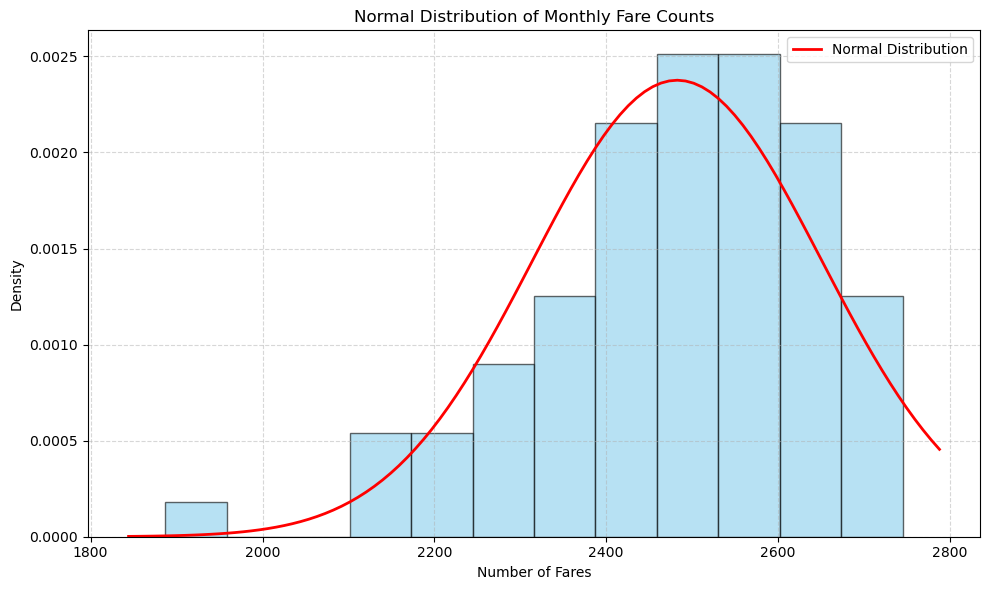

In [29]:
# Make a copy of the DataFrame to preserve the original data
df_transformed = df.copy()

# Remove timezone information from 'pickup_datetime'
df_transformed['pickup_datetime'] = df_transformed['pickup_datetime'].dt.tz_localize(None)

# Now extract the month and year without the timezone warning
df_transformed['year_month'] = df_transformed['pickup_datetime'].dt.to_period('M')

# Calculate the total number of fares for each month
monthly_fare_counts = df_transformed.groupby('year_month').size().reset_index(name='fare_count')

# Plotting the histogram of monthly fare counts
plt.figure(figsize=(10, 6))
plt.hist(monthly_fare_counts['fare_count'], bins=12, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating mean and standard deviation of the monthly fare counts
mean = monthly_fare_counts['fare_count'].mean()
std_dev = monthly_fare_counts['fare_count'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

# Adding plot title and labels
plt.title('Normal Distribution of Monthly Fare Counts')
plt.xlabel('Number of Fares')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

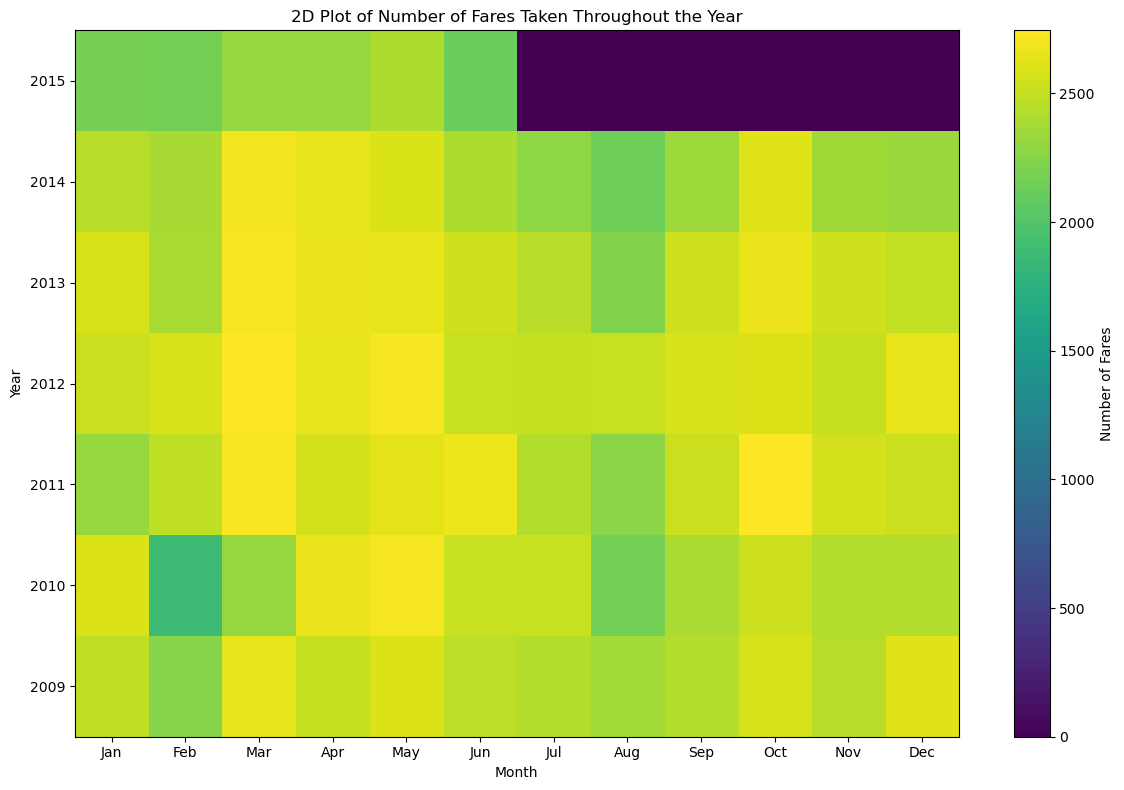

In [30]:
# Make a copy of the DataFrame to preserve the original data
df_transformed = df.copy()

# Remove timezone information from 'pickup_datetime'
df_transformed['pickup_datetime'] = df_transformed['pickup_datetime'].dt.tz_localize(None)

# Extract the year and month separately
df_transformed['year'] = df_transformed['pickup_datetime'].dt.year
df_transformed['month'] = df_transformed['pickup_datetime'].dt.month

# Calculate the total number of fares for each month of each year
monthly_fare_counts = df_transformed.groupby(['year', 'month']).size().unstack(fill_value=0)

# Plotting the 2D heatmap
plt.figure(figsize=(12, 8))
plt.imshow(monthly_fare_counts, aspect='auto', cmap='viridis', origin='lower')

# Adding x-ticks and y-ticks
plt.xticks(ticks=np.arange(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks(ticks=np.arange(len(monthly_fare_counts.index)), labels=monthly_fare_counts.index)

# Adding plot title and labels
plt.title('2D Plot of Number of Fares Taken Throughout the Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.colorbar(label='Number of Fares')

# Display the plot
plt.tight_layout()
plt.show()

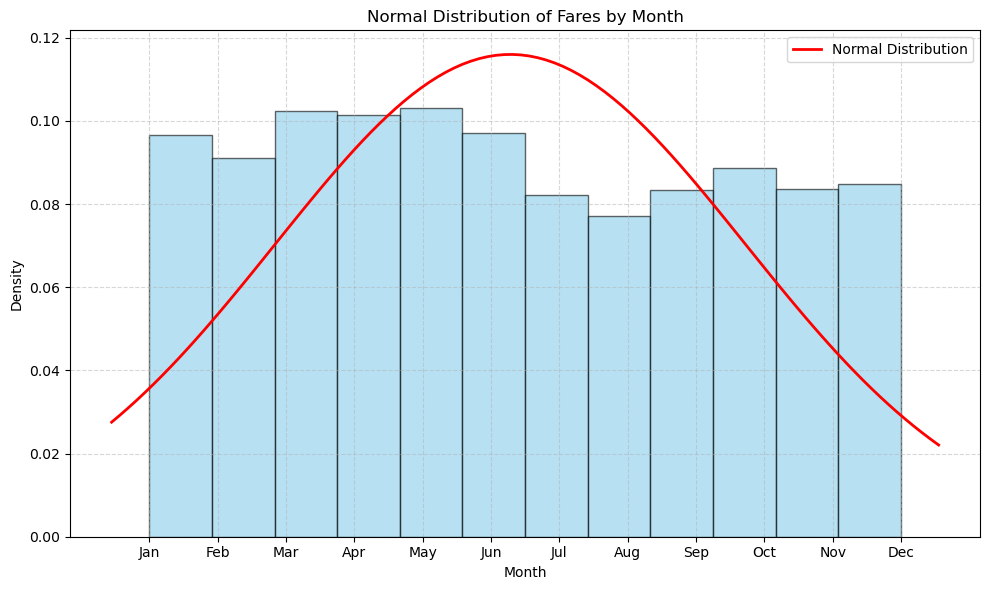

In [31]:
# Make a copy of the DataFrame to preserve the original data
df_transformed = df.copy()

# Remove timezone information from 'pickup_datetime'
df_transformed['pickup_datetime'] = df_transformed['pickup_datetime'].dt.tz_localize(None)

# Extract the month from 'pickup_datetime'
df_transformed['month'] = df_transformed['pickup_datetime'].dt.month

# Calculate the frequency of fares per month
monthly_counts = df_transformed['month'].value_counts().sort_index()

# Plotting the histogram of monthly fare counts
plt.figure(figsize=(10, 6))
plt.hist(df_transformed['month'], bins=12, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating the mean and standard deviation of the monthly counts
mean = df_transformed['month'].mean()
std_dev = df_transformed['month'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

# Adding plot title and labels
plt.title('Normal Distribution of Fares by Month')
plt.xlabel('Month')
plt.ylabel('Density')
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Number of fares drops down in 2015 because the dataset was extracted probaby halfway through the year so we missed the remainder of fares that year.

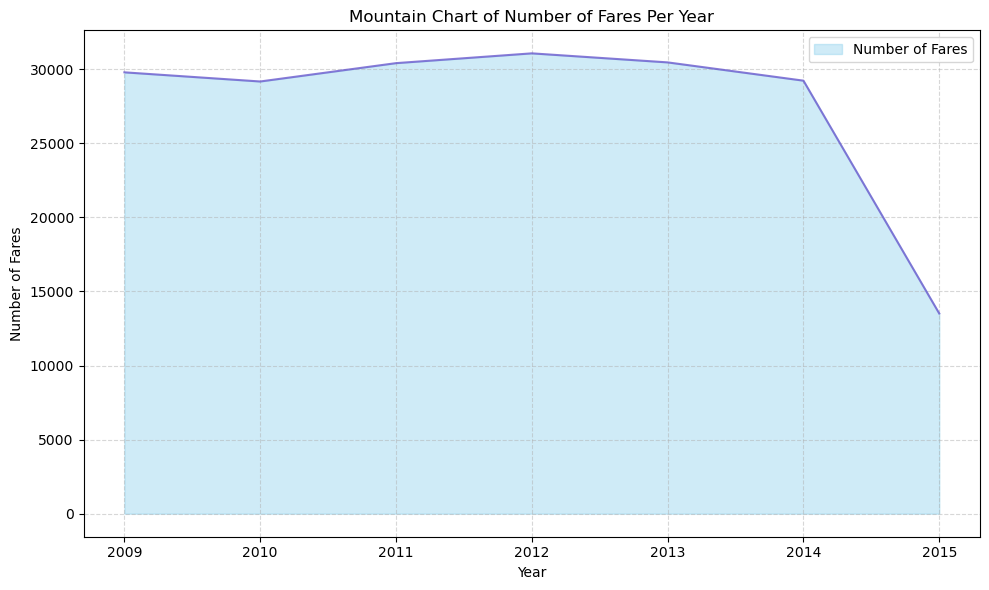

In [32]:
# Make a copy of the DataFrame to preserve the original data
df_transformed = df.copy()

# Remove timezone information from 'pickup_datetime'
df_transformed['pickup_datetime'] = df_transformed['pickup_datetime'].dt.tz_localize(None)

# Extract the year from 'pickup_datetime'
df_transformed['year'] = df_transformed['pickup_datetime'].dt.year

# Calculate the total number of fares for each year
annual_fare_counts = df_transformed['year'].value_counts().sort_index()

# Plotting the mountain chart (area chart)
plt.figure(figsize=(10, 6))
plt.fill_between(annual_fare_counts.index, annual_fare_counts.values, color="skyblue", alpha=0.4, label='Number of Fares')
plt.plot(annual_fare_counts.index, annual_fare_counts.values, color="Slateblue", alpha=0.8)

# Adding plot title and labels
plt.title('Mountain Chart of Number of Fares Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fares')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


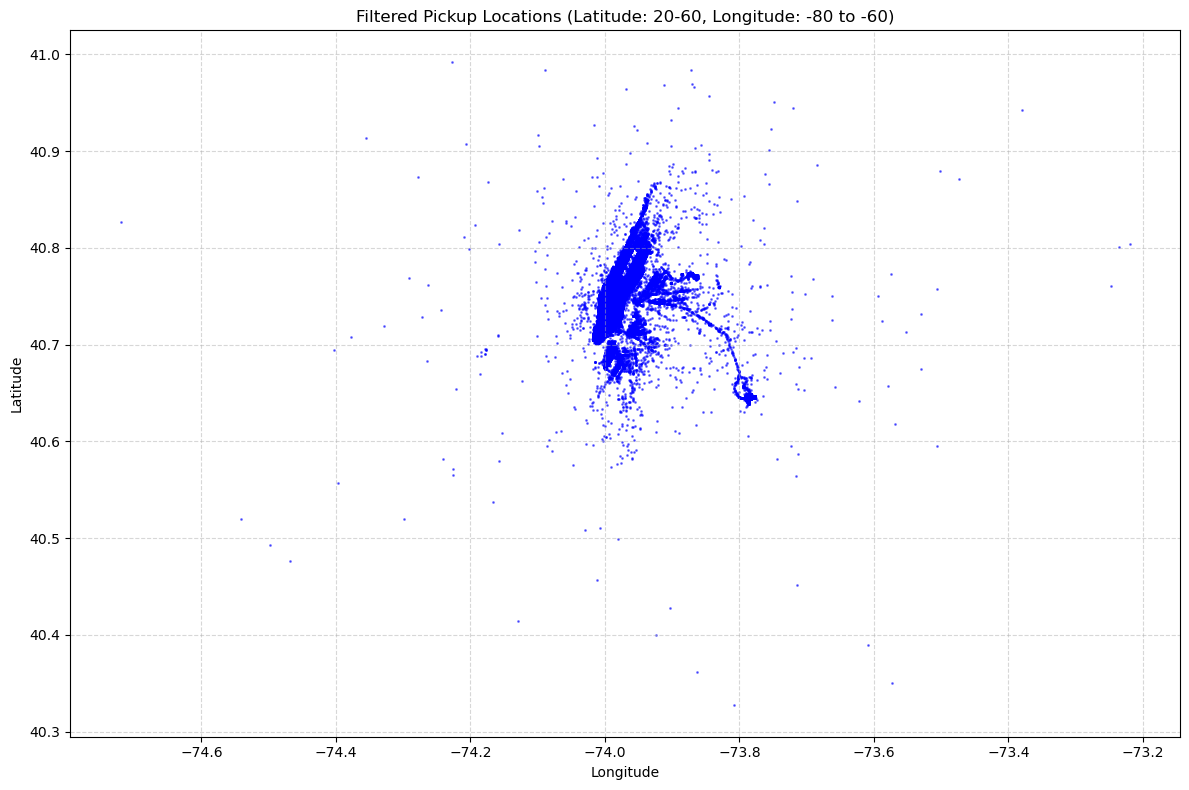

In [36]:
df_filtered = df.copy()

# Filter data where latitude is between 20 and 60, and longitude is between -80 and -60
df_filtered = df_filtered[(df_filtered['pickup_latitude'] >= 40.6) & (df_filtered['pickup_latitude'] <= 40.9) &
                 (df_filtered['pickup_longitude'] >= -74.2) & (df_filtered['pickup_longitude'] <= -73.6)]

# Extract filtered pickup latitude and longitude
pickup_latitudes = df_filtered['pickup_latitude']
pickup_longitudes = df_filtered['pickup_longitude']

# Plotting the filtered pickup locations
plt.figure(figsize=(12, 8))
plt.scatter(pickup_longitudes, pickup_latitudes, s=1, alpha=0.5, color='blue')

# Adding plot title and labels
plt.title('Filtered Pickup Locations (Latitude: 20-60, Longitude: -80 to -60)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()